# ERA5

## Import packages

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

# Import some extra functions from utils folder
import sys
sys.path.insert(1, 'utils') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:55:52) 
[GCC 7.5.0]
Virtual memory usage - total: 31 GB / available: 24 GB / percent used: 21.9 %


## Download ERA5

1. Go to https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5
2. Search `ERA5 monthly averaged data on single levels from 1979 to present`
3. Download:
    - Product type: Monthly averaged reanalysis
    - Variable: 2m temperature
    - Select all years (except 2021) / months / time
    - Geographical area: Whole available region
    - Format: NetCDF (experimental)
4. Login/register to submit request (create an account if you don't have one)
5. Go back down on the page and click on Submit Form
6. Click on download, cancel, then right click on the download button and copy the link path, then paste it on the cell bellow besides the `wget` command

Remark: It should be around 1Go

In [12]:
!wget https://download-0010.copernicus-climate.eu/cache-compute-0010/cache/data5/adaptor.mars.internal-1639358256.5415273-8683-12-4ea3d2af-aff3-42c0-b05b-7329e6435eaf.nc

--2021-12-08 17:02:52--  https://download-0002.copernicus-climate.eu/cache-compute-0002/cache/data9/adaptor.mars.internal-1638976091.1406703-18433-15-e8d5f186-7255-4bb5-8aa5-a2830d7d4944.nc
Résolution de download-0002.copernicus-climate.eu (download-0002.copernicus-climate.eu)… 136.156.132.198
Connexion à download-0002.copernicus-climate.eu (download-0002.copernicus-climate.eu)|136.156.132.198|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1046557652 (998M) [application/x-netcdf]
Sauvegarde en : « adaptor.mars.internal-1638976091.1406703-18433-15-e8d5f186-7255-4bb5-8aa5-a2830d7d4944.nc »

adaptor.mars.intern 100%[===================>] 998,07M  4,34MB/s    ds 2m 38s  

2021-12-08 17:05:30 (6,32 MB/s) — « adaptor.mars.internal-1638976091.1406703-18433-15-e8d5f186-7255-4bb5-8aa5-a2830d7d4944.nc » sauvegardé [1046557652/1046557652]



7. Rename the downloaded file to `ERA5.nc`

## Read ERA5 file

In [2]:
ds = xr.open_dataset('ERA5.nc')
ds # ds as dataset

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 504)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-08 15:08:23 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [12]:
# Let's try to get the temperature in °C (uncomment this cell and run this once)
# da = ds.t2m - 273.15
# da

Oups if you are on Binder the kernel as shut down! This is because we have a very limited available amount of RAM (2Go). So we are going to have to trick to make this computation... Hopefully `xarray` comes with `dask` that allows easy parallel computation. Here we are not going to use the parallelization, but we are going to take advantage of Dask for splitting our data into multiple chunks to reduce to RAM usage!

See more: http://xarray.pydata.org/en/stable/user-guide/dask.html

## Check size

In [3]:
# https://stackoverflow.com/a/14822210/6344670
import math

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [4]:
convert_size(ds.t2m.nbytes)

'1.95 GB'

## Make chunks
http://xarray.pydata.org/en/stable/user-guide/dask.html#what-is-a-dask-array

![](http://xarray.pydata.org/en/stable/_images/dask_array.png)

In [5]:
ds.dims

Frozen({'longitude': 1440, 'latitude': 721, 'time': 504})

In [6]:
ds = ds.chunk(chunks={"longitude": 360, "latitude": 360})
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 504)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(504, 360, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-08 15:08:23 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [7]:
ds.t2m.data

dask.array<xarray-t2m, shape=(504, 721, 1440), dtype=float32, chunksize=(504, 360, 360), chunktype=numpy.ndarray>

You can see that our dataset have been splited into 12 chunks of about 250 MB what is better than the 2 Go full array! So let's try back to convert to °C!

In [7]:
da = ds.t2m - 273.15
da

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
dask.array<sub, shape=(504, 721, 1440), dtype=float32, chunksize=(504, 360, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01

As you can see the execution of the cell is almost instantaneous. Why is this?Because the advantage of `dask.array` is that it is not loaded into memory until explicitly requested with `.load()`, `.compute()` or `.values`. It only builds graphs to prepare the computation. 

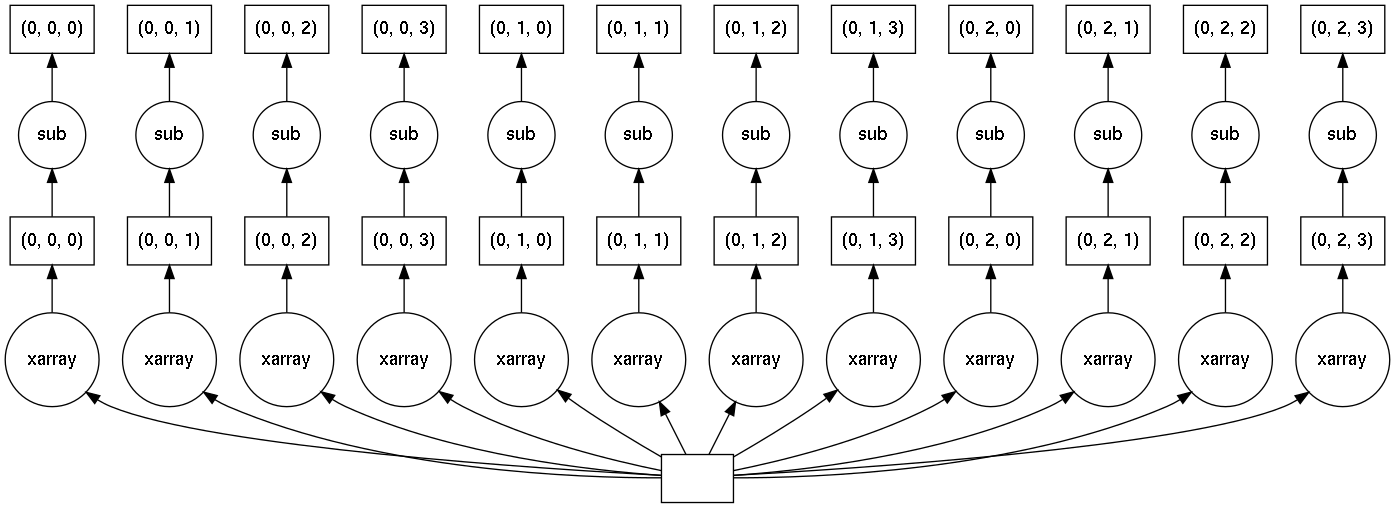

In [38]:
dask.visualize(da)

## Compute and plot climatology
Using the examples in the notebook `01_xarray_get_started.ipynb` try to calculate the climatology and make a graph with a projection (directly with Cartopy or Proplot). 

Remember to check the size of your `dask.array` before loading it into memory (`clim.load()`), which will make it easier to produce the graph (otherwise it will redo the calculation every time you make a graph).

In [8]:
clim = da.mean('time')
clim

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float32, chunksize=(360, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

In [17]:
clim.load()

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[-13.885791 , -13.885791 , -13.885791 , ..., -13.885791 ,
        -13.885791 , -13.885791 ],
       [-13.8681755, -13.868014 , -13.867904 , ..., -13.868731 ,
        -13.868519 , -13.868374 ],
       [-13.804141 , -13.803757 , -13.803349 , ..., -13.805362 ,
        -13.805054 , -13.8046255],
       ...,
       [-44.865486 , -44.864765 , -44.863255 , ..., -44.867443 ,
        -44.8662   , -44.86542  ],
       [-44.961185 , -44.960022 , -44.958954 , ..., -44.963005 ,
        -44.962418 , -44.961845 ],
       [-45.39447  , -45.39447  , -45.39447  , ..., -45.39447  ,
        -45.39447  , -45.39447  ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

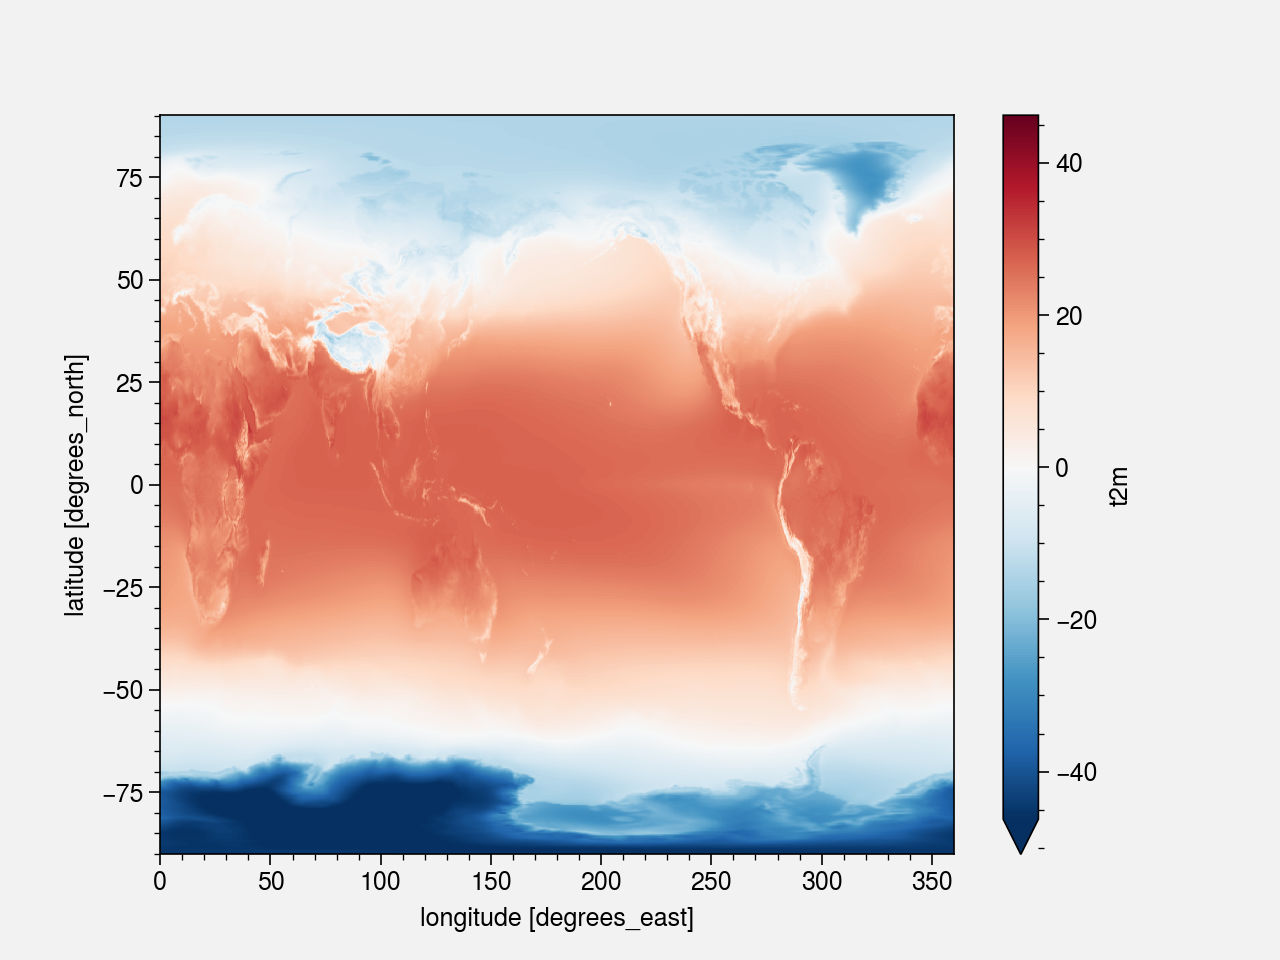

In [18]:
clim.plot(robust=True)

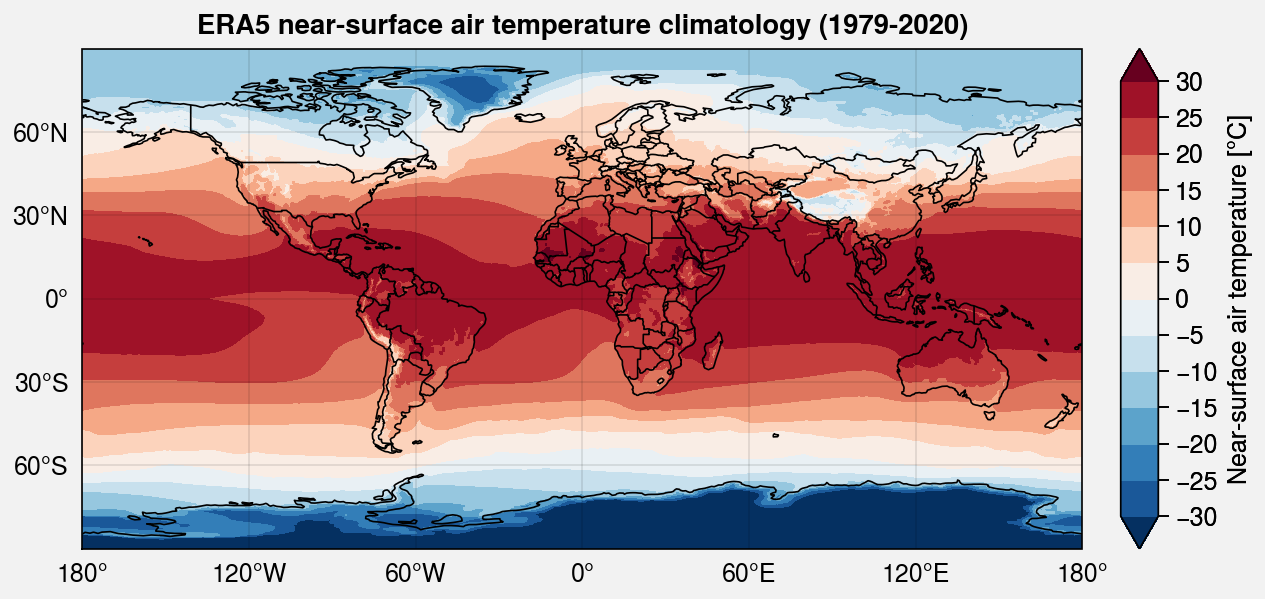

In [47]:
cmap='RdBu_r'
levels=plot.arange(-30,30,5)
extend='both'

fig, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', axwidth=5)

axs[0].contourf(
    clim, colorbar='r', cmap=cmap, levels=levels, extend=extend, 
    colorbar_kw={'label': 'Near-surface air temperature [°C]'}
)

axs.format(
    labels=True, coast=True, borders=True,
    suptitle='ERA5 near-surface air temperature climatology (1979-2020)'
)

## Seasonal and regional plots
Try to make seasonal climatology plots on the country you come from.

Since the longitude data goes from 0 to 360, it is a bit more complicated if your region is around longitude 0. Two solutions, either you use the `.roll()` function to shift your whole dataset, or you use a mask with `.where()` (this last solution seems to me the easiest). You can also use the option `globe=True` in your `contourf()` with proplot to fill the 0 longitude.

Also note that the latitudes are in descending order. So you have to reverse the values in the `.slice()`

### Select zone

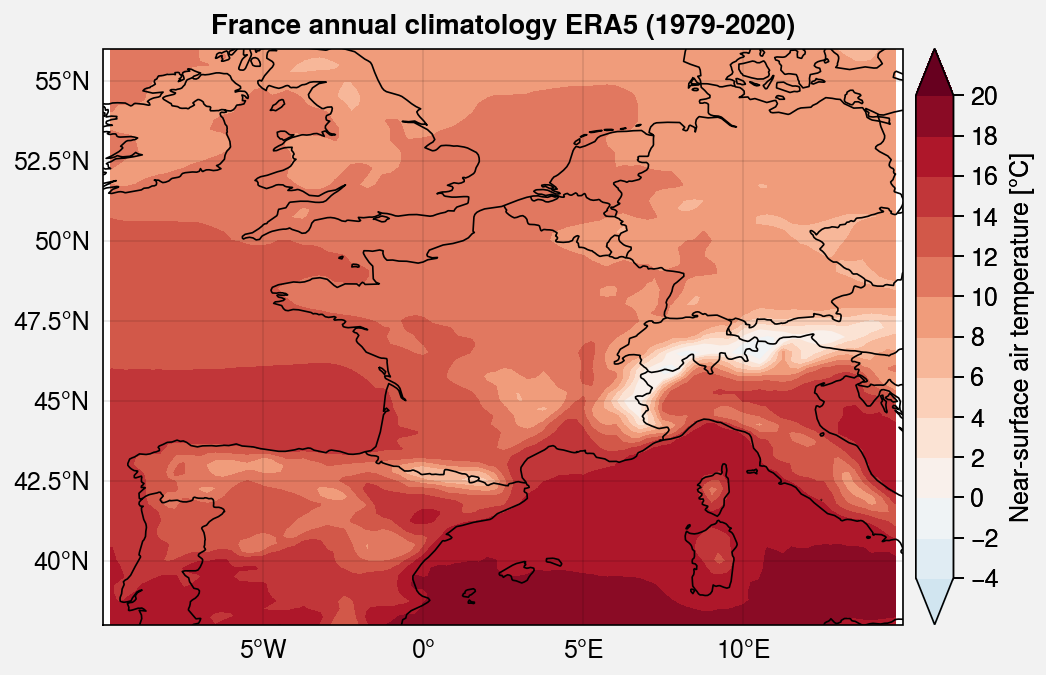

In [92]:
cmap='RdBu_r'
levels=plot.arange(-4,20,2)
extend='both'
latmin=38 ; latmax=56 ; lonmin=-10 ; lonmax=15

fig, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', axwidth=4)

axs[0].contourf(
    clim.sel(latitude=slice(latmax,latmin)).where( (clim.longitude > 360+lonmin) | (clim.longitude < lonmax)), 
    colorbar='r', cmap=cmap, levels=levels, extend=extend, globe=True, 
    norm='div', # norm=plot.Norm('diverging', fair=False),
    colorbar_kw={'label': 'Near-surface air temperature [°C]'}
)

axs.format(
    labels=True, coast=True, borders=True, reso='med',
    latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
    suptitle='France annual climatology ERA5 (1979-2020)'
)

### Compute and plot seasonal climatologies

In [85]:
clim_seas = da.sel(latitude=slice(latmax,latmin)).where( (clim.longitude > 360+lonmin) | (clim.longitude < lonmax)) \
                .groupby('time.season').mean('time').load()

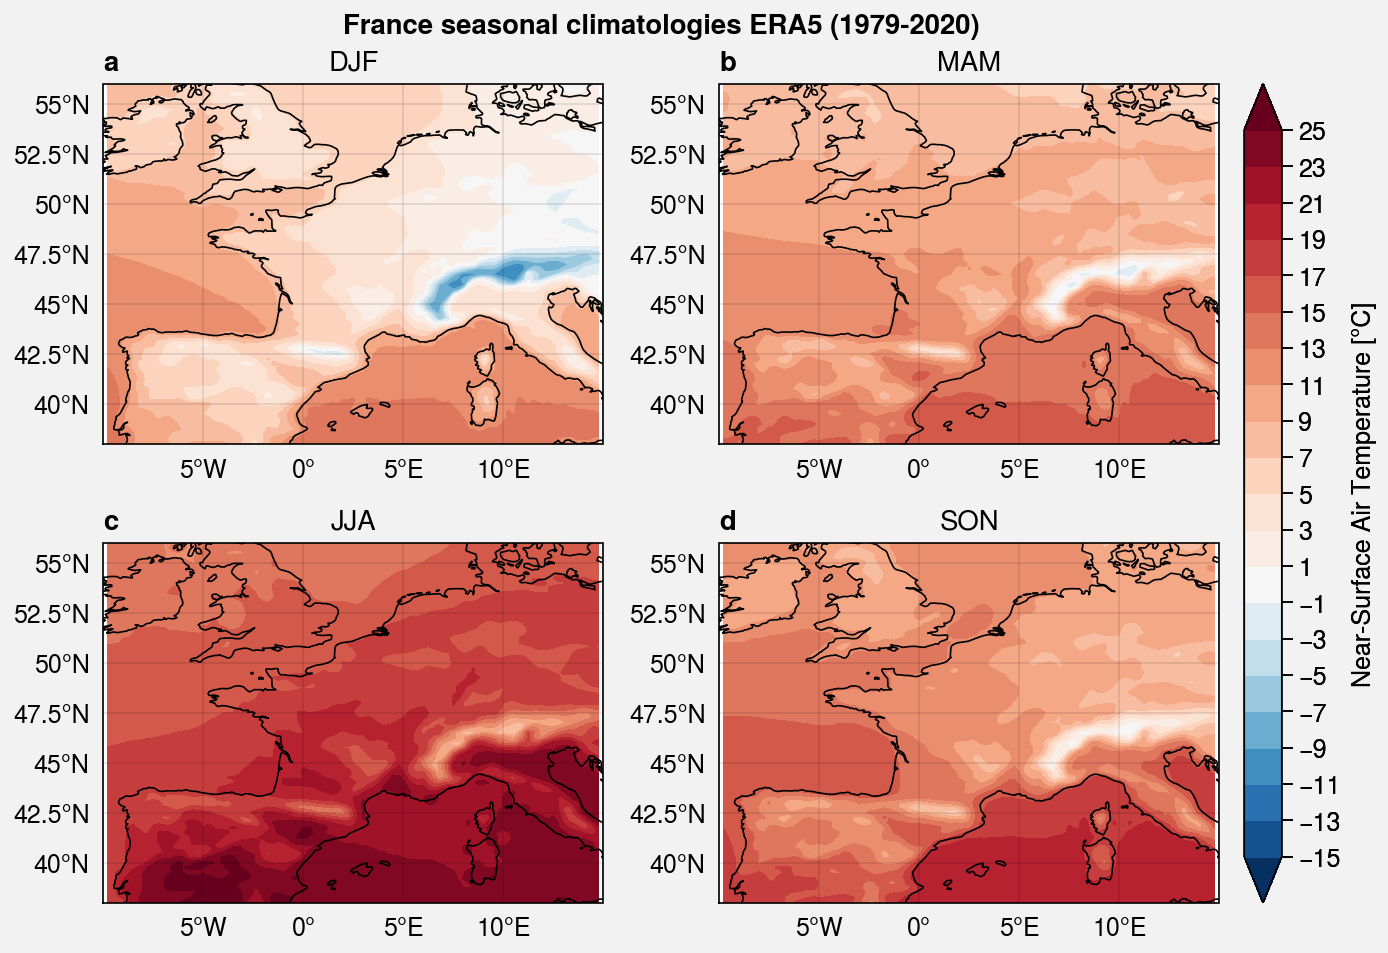

In [119]:
cmap='RdBu_r'
levels=plot.arange(-15,25,2)
extend='both'

fig, axs = plot.subplots(nrows=2, ncols=2, proj='cyl')

seasons = ['DJF', 'MAM', 'JJA', 'SON']
for i, ax in enumerate(axs):
    m = ax.contourf(
        clim_seas.sel(season=seasons[i]), cmap=cmap, levels=levels, extend=extend, globe=True, 
        norm=plot.Norm('diverging', fair=False)
    )
    ax.format(title=seasons[i])

axs.format(
    labels=True, coast=True, abc=True, reso='med',
    latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
    suptitle='France seasonal climatologies ERA5 (1979-2020)'
)

fig.colorbar(m, label='Near-Surface Air Temperature [°C]')
fig.save('img/france_seasonal_clim_t2m.jpg')

## Share your plots!

Go to the following link and upload your figure for your country!

https://app.mural.co/t/variabiliteclimatique4363/m/variabiliteclimatique4363/1638958705203/74c3a90eb11e8e6898545872d80b8a41f0cd90ff?sender=ufcbfba826e94d93c633c7410

## Compute trends

### Make yearly mean

In [9]:
da_year = da.resample(time='Y').mean('time')
da_year.load()

<xarray.DataArray 't2m' (time: 42, latitude: 721, longitude: 1440)>
array([[[-15.298064 , -15.298064 , -15.298064 , ..., -15.298064 ,
         -15.298064 , -15.298064 ],
        [-15.106027 , -15.10632  , -15.106465 , ..., -15.10632  ,
         -15.106174 , -15.10632  ],
        [-14.927503 , -14.928825 , -14.929561 , ..., -14.926323 ,
         -14.926765 , -14.926913 ],
        ...,
        [-44.790485 , -44.789318 , -44.78726  , ..., -44.792988 ,
         -44.79166  , -44.790928 ],
        [-44.83089  , -44.829426 , -44.827953 , ..., -44.83369  ,
         -44.832508 , -44.83163  ],
        [-45.233643 , -45.233643 , -45.233643 , ..., -45.233643 ,
         -45.233643 , -45.233643 ]],

       [[-14.361809 , -14.361809 , -14.361809 , ..., -14.361809 ,
         -14.361809 , -14.361809 ],
        [-14.27908  , -14.27967  , -14.280109 , ..., -14.277026 ,
         -14.277759 , -14.278347 ],
        [-14.159036 , -14.160801 , -14.161244 , ..., -14.1547785,
         -14.155953 , -14.157716 ],
...
        [-44.575672 , -44.57552  , -44.574493 , ..., -44.576405 ,
         -44.57538  , -44.57523  ],
        [-44.59933  , -44.59845  , -44.59786  , ..., -44.600506 ,
         -44.600357 , -44.599476 ],
        [-44.965336 , -44.965336 , -44.965336 , ..., -44.965336 ,
         -44.965336 , -44.965336 ]],

       [[-12.439185 , -12.439185 , -12.439185 , ..., -12.439185 ,
         -12.439185 , -12.439185 ],
        [-12.491937 , -12.490762 , -12.490173 , ..., -12.493552 ,
         -12.492965 , -12.492375 ],
        [-12.494725 , -12.49282  , -12.491351 , ..., -12.499279 ,
         -12.497223 , -12.495755 ],
        ...,
        [-44.294735 , -44.293415 , -44.291943 , ..., -44.29738  ,
         -44.29547  , -44.29488  ],
        [-44.343075 , -44.342194 , -44.34087  , ..., -44.345577 ,
         -44.344837 , -44.34425  ],
        [-44.755672 , -44.755672 , -44.755672 , ..., -44.755672 ,
         -44.755672 , -44.755672 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-31 1980-12-31 ... 2020-12-31
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

### Spatially averaged time series

In [10]:
# Spatially averaged time series
ts = u.spatial_average(da_year)
ts.load()

<xarray.DataArray (time: 42)>
array([13.942432 , 14.07366  , 14.107058 , 13.90777  , 14.102641 ,
       13.890002 , 13.849628 , 13.938397 , 14.093792 , 14.125939 ,
       14.007601 , 14.239014 , 14.18425  , 13.952181 , 13.997986 ,
       14.034312 , 14.212081 , 14.08212  , 14.204334 , 14.392961 ,
       14.124093 , 14.119023 , 14.27903  , 14.375711 , 14.362753 ,
       14.301396 , 14.463632 , 14.415544 , 14.408132 , 14.2756605,
       14.406318 , 14.501998 , 14.36014  , 14.411281 , 14.438498 ,
       14.477662 , 14.627028 , 14.810641 , 14.715088 , 14.635329 ,
       14.77068  , 14.803615 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-31 1980-12-31 ... 2020-12-31

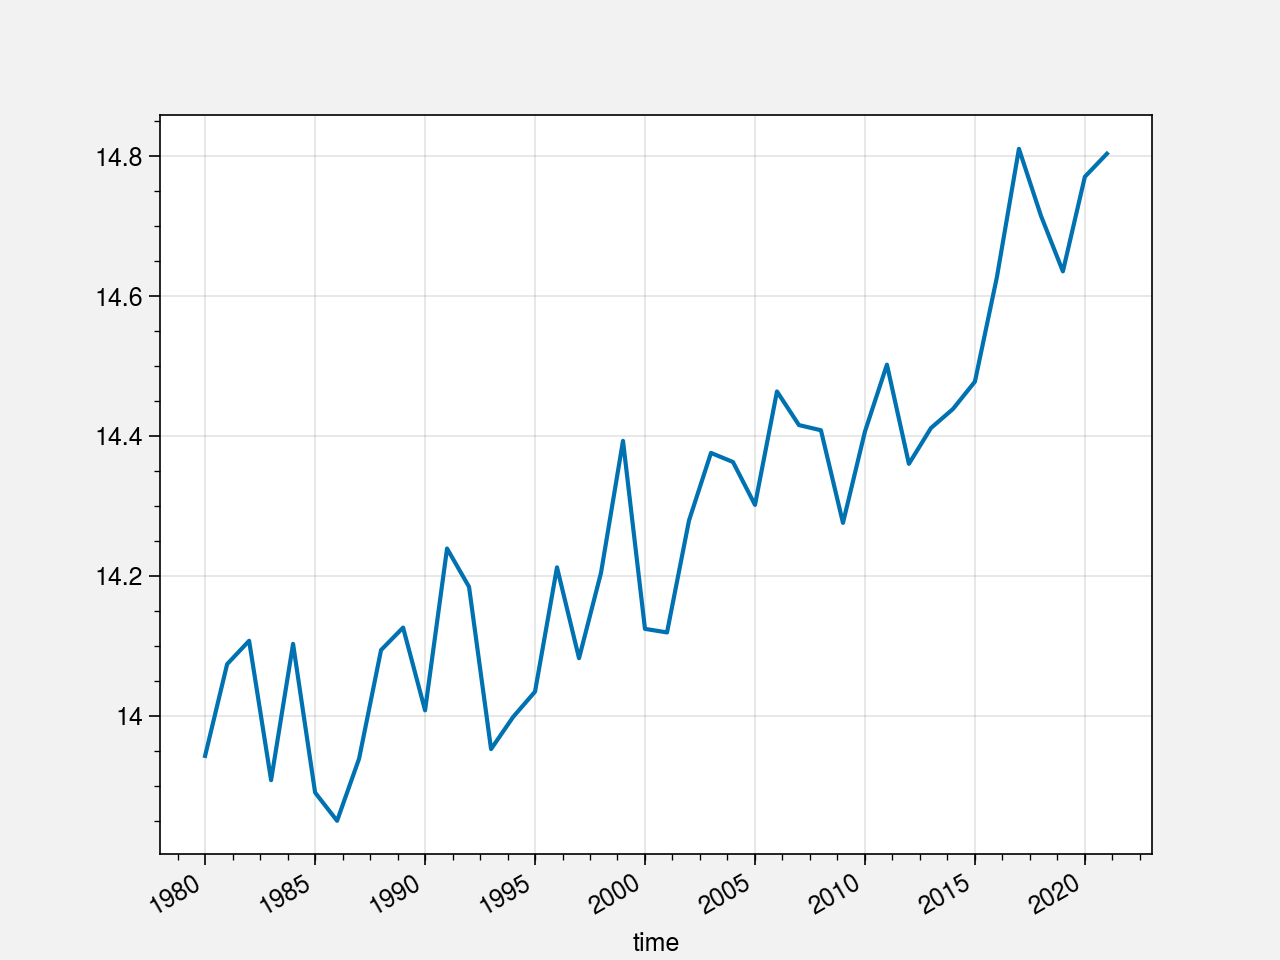

In [21]:
ts.plot()

### Make linear regression
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

In [11]:
# Make linear regression
reg = stats.linregress(ts['time.year'], ts)
reg

LinregressResult(slope=0.019198540302026543, intercept=-24.115542056253148, rvalue=0.9042319759681927, pvalue=2.2826837095381375e-16, stderr=0.0014336018197006382, intercept_stderr=2.86653950617479)

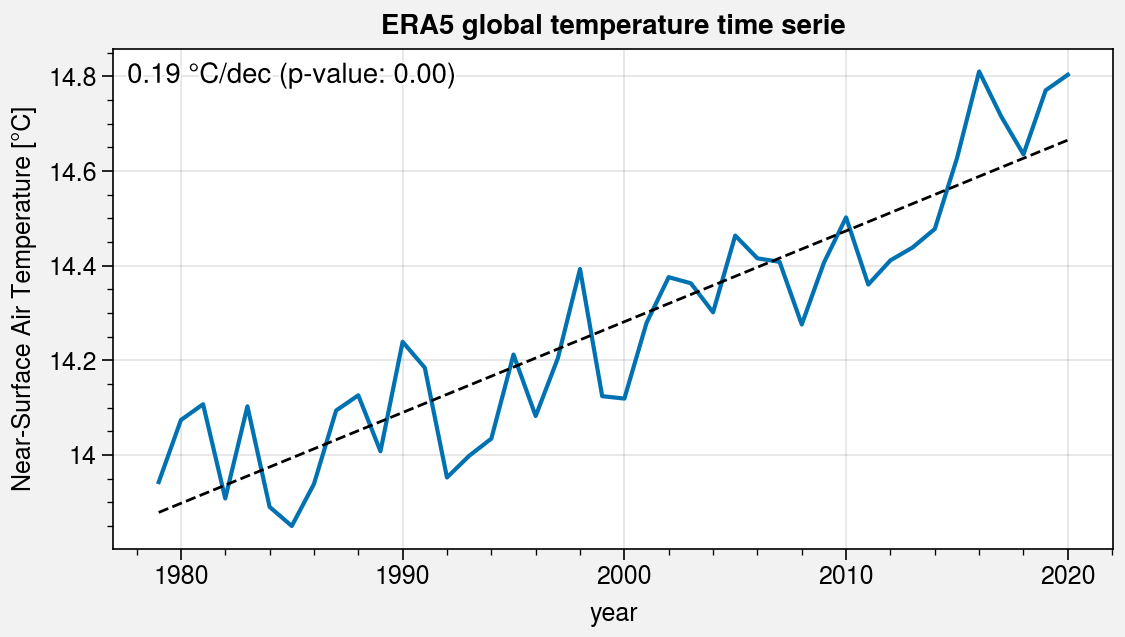

In [14]:
fig, axs = plot.subplots(axwidth=5, aspect=2)

x = ts['time.year']

# Plot time serie
axs[0].plot(x, ts)

# Plot regression
y = reg.slope*x + reg.intercept
axs[0].plot(x, y, color='k', linewidth=1, linestyle='--')

# Show regression
axs[0].format(
    ultitle='{:.2f} °C/dec (p-value: {:.2f})'.format(reg.slope*10, reg.pvalue)
)

axs.format(
    xlabel='year',
    ylabel='Near-Surface Air Temperature [°C]',
    suptitle='ERA5 global temperature time serie'
)

### Spatial trends
It would be very long to make a loop on each lat/lon, so we can vectorize the calculation with `apply_ufunc` of xarray

In [24]:
def trend(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

In [25]:
%%time
for arr_name, arr in zip(
    ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], 
    trend(da_year['time.year'], da_year, 'time')
):
    da_year[arr_name] = arr

CPU times: user 3min 15s, sys: 0 ns, total: 3min 15s
Wall time: 3min 15s


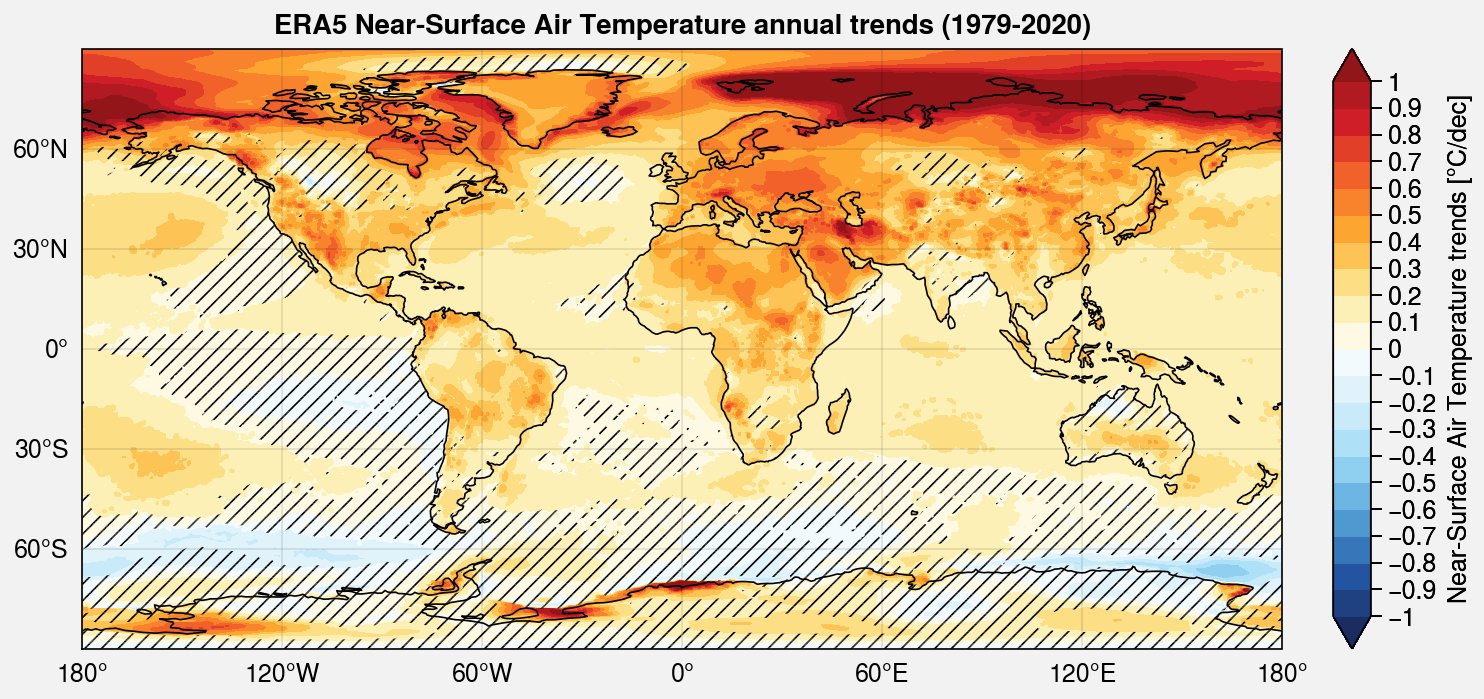

In [26]:
fig, axs = plot.subplots(proj='cyl', axwidth=6)

cmap='ColdHot'
levels=plot.arange(-1,1,0.1)
extend='both'

m = axs[0].contourf(da_year.slope*10, cmap=cmap, levels=levels, extend=extend)
axs[0].contourf(da_year.pvalue.where(da_year.pvalue>0.05), hatches=['////'], alpha=0)

fig.colorbar(m, label='Near-Surface Air Temperature trends [°C/dec]', formatter=('simple', 3))

# Format
axs.format(
    labels=True, coast=True,
    suptitle='ERA5 Near-Surface Air Temperature annual trends (1979-2020)'
)

### Show Arctic Amplification
Try to show Arctic Amplification with time series

In [24]:
ts_arctic = u.spatial_average(da_year.sel(latitude=slice(90,60)))

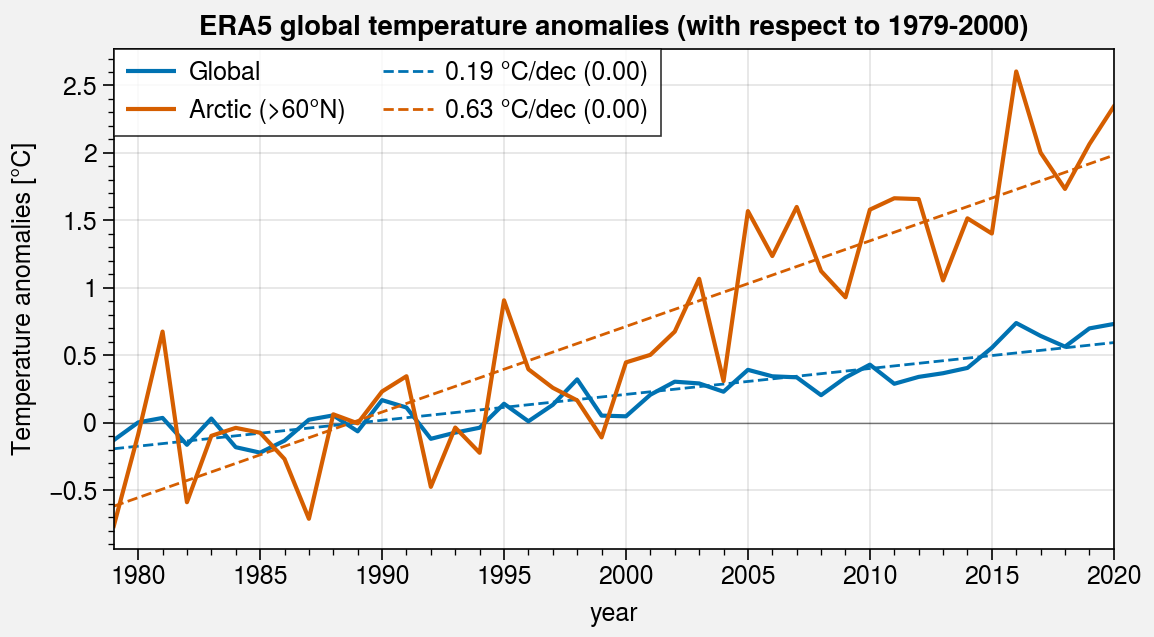

In [59]:
fig, axs = plot.subplots(axwidth=5, aspect=2)

x = ts['time.year']

ts_list = [ts, ts_arctic]
labels = ['Global', 'Arctic (>60°N)']

for i, t in enumerate(ts_list):
    # Compute clim on reference period to make anomalies
    clim = t.sel(time=slice('1979', '2000')).mean()
    
    # Plot time serie
    axs[0].plot(x, t-clim, color='C'+str(i), label=labels[i])

    # Plot regression
    reg = stats.linregress(t['time.year'], t-clim)
    y = reg.slope*x + reg.intercept
    axs[0].plot(x, y, color='C'+str(i), linewidth=1, linestyle='--', label='{:.2f} °C/dec ({:.2f})'.format(reg.slope*10, reg.pvalue))

    
axs[0].legend(ncol=2)

# Add 0 line
axs[0].hlines(0, x.min(), x.max(), linewidth=0.5, alpha=0.5)

axs.format(
    xlabel='year',
    ylabel='Temperature anomalies [°C]',
    suptitle='ERA5 global temperature anomalies (with respect to 1979-2000)',
    xlim=(x.min(), x.max())
)